# Convolutional neural networks

Now let's take a look at *convolutional neural networks* (CNNs), the models people really use for classifying images. 

In [1]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

## The CIFAR10 dataset, STILL

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
image_size = (32, 32, 3)

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Convolutional neural networks (CNNs)

In the multilayer perceptron case, we connected the nodes of our neural networks in what seems like the simplest possible way. Every node in each layer was connected to every node in the subsequent layers. 

<center>![](../img/multilayer-perceptron.png)</center>

This can require a lot of parameters! If our input were a 256x256 color image (still quite small for a photograph), and our network had 1,000 nodes in the first hidden layer, then our first weight matrix would require (256x256x3)x1000 parameters. That's nearly 200 million. Moreover the hidden layer would ignore all the spatial structure in the input image even though we know the local structure represents a powerful source of prior knowledge. 

Convolutional neural networks incorporate convolutional layers. These layers associate each of their nodes with a small window, called a *receptive field*, in the previous layer, instead of connecting to the full layer. This allows us to first learn local features via transformations that are applied in the same way for the top right corner as for the bottom left. Then we collect all this local information to predict global qualities of the image (like whether or not it depicts a dog). 

<center>![](http://cs231n.github.io/assets/cnn/depthcol.jpeg)</center>

(Image credit: Stanford cs231n http://cs231n.github.io/assets/cnn/depthcol.jpeg)

In short, there are two new concepts you need to grok here. First, we'll be introducting *convolutional* layers. Second, we'll be interleaving them with *pooling* layers. 

## Parameters

Each node in a convolutional layer is associated with a 3D block (height x width x channel) in the input tensor. Moreover, the convolutional layer itself has multiple output channels. So the layer is parameterized by a 4 dimensional weight tensor, commonly called a *convolutional kernel*. 

The output tensor is produced by sliding the kernel across the input image skipping locations according to a pre-defined *stride* (but we'll just assume that to be 1 in this tutorial). Let's initialize some such kernels from scratch.

## Max pooling

The other new component of this model is the pooling layer. Pooling gives us a way to downsample in the spatial dimensions. Early convnets typically used average pooling, but max pooling tends to give better results. 

## Loss function

Still the cross entropy.

In [3]:
criterion = nn.CrossEntropyLoss()

In [4]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 9 * 9, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 128 * 9 * 9)
        x = self.classifier(x)
        return x

In [5]:
net = ConvNet()
net.to(device)

# also the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(1, 33):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    if epoch % 4 == 0:
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the test set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the test set
    with T.no_grad():
        correct = 0
        total = 0
        test_running_loss = .0
        for data in test_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_running_loss /= len(test_loader)
        test_loss.append(test_running_loss)
        test_running_acc = correct / total
        test_acc.append(test_running_acc)
        
        if epoch % 4 == 0:
            print('Test Acc.  => {:.3f}%'.format(100 * test_running_acc), end=' | ')
            print('Test Loss  => {:.5f}'.format(test_running_loss))

print('Finished Training')


Epoch: 4
Train Acc. => 59.444% | Train Loss => 1.14581
Test Acc.  => 60.100% | Test Loss  => 1.11926

Epoch: 8
Train Acc. => 69.432% | Train Loss => 0.87285
Test Acc.  => 67.090% | Test Loss  => 0.93443

Epoch: 12
Train Acc. => 75.260% | Train Loss => 0.70139
Test Acc.  => 70.550% | Test Loss  => 0.85366

Epoch: 16
Train Acc. => 81.078% | Train Loss => 0.54445
Test Acc.  => 71.850% | Test Loss  => 0.83311

Epoch: 20
Train Acc. => 85.854% | Train Loss => 0.41174
Test Acc.  => 72.440% | Test Loss  => 0.82984

Epoch: 24
Train Acc. => 90.186% | Train Loss => 0.28792
Test Acc.  => 73.930% | Test Loss  => 0.84632

Epoch: 28
Train Acc. => 93.288% | Train Loss => 0.19497
Test Acc.  => 73.710% | Test Loss  => 0.91641

Epoch: 32
Train Acc. => 95.684% | Train Loss => 0.13074
Test Acc.  => 74.170% | Test Loss  => 0.99424
Finished Training


## Conclusion

Nice! With the superior CNN, we reach 74% accuracy on CIFAR10 dataset!

## Visualization

In [7]:
import matplotlib.pyplot as plt

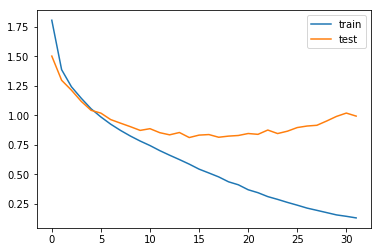

In [8]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

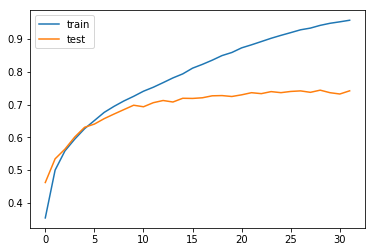

In [9]:
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()
plt.show()